##Install Rendering dependancies, takes around 45 seconds



In [19]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Gym Pacman Environment Dependancies

In [2]:
#!apt-get update > /dev/null 2>&1
#!apt-get install cmake > /dev/null 2>&1
#!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

## Mount G-drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd /content/drive/Shareddrives/RL-project/Models/C51/

/content/drive/Shareddrives/RL-project/Models/C51


In [4]:
#!pwd
#!ls

/content/drive/Shareddrives/RL-project/Models/C51


# Imports and Helper functions


In [20]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [6]:
from score_logger import ScoreLogger

# Pacman!

In [45]:
import random
from collections import deque
from IPython import display as ipythondisplay
from tensorflow.keras.layers import Dense, Input, Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model

In [42]:
# Make sure we have GPU available to train
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
!nvidia-smi

True
/device:GPU:0
Sun Nov 29 08:25:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   50C    P0    27W / 140W |   5774MiB /  6077MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

state_size:  128
action size:  9
Epsilon update:  0.9333400000000001
Epsilon update:  0.8666800000000001
Epsilon update:  0.8000200000000002
Epsilon update:  0.7333600000000002
Epsilon update:  0.6667000000000003
Epsilon update:  0.6000400000000004
Epsilon update:  0.5333800000000004
Epsilon update:  0.4667200000000004
Epsilon update:  0.4000600000000004
Epsilon update:  0.3334000000000004
Epsilon update:  0.2667400000000004
Epsilon update:  0.20008000000000042
Epsilon update:  0.13342000000000043
Epsilon update:  0.06676000000000043
Epsilon update:  0.00010000000000043308
Epsilon update:  -0.06655999999999956
episode: 0   score: 200.0   memory length: 1921   epsilon: -0.06655999999999956
episode: 1   score: 180.0   memory length: 3818   epsilon: -0.06655999999999956
episode: 2   score: 260.0   memory length: 5931   epsilon: -0.06655999999999956
episode: 3   score: 170.0   memory length: 7604   epsilon: -0.06655999999999956
episode: 4   score: 230.0   memory length: 9765   epsilon: -0.

KeyboardInterrupt: 

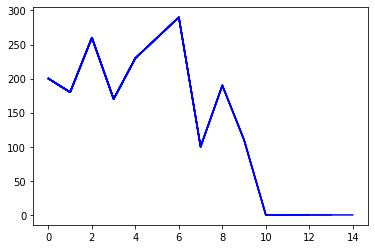

In [49]:
# TODO: allow passing of hyper params as a colab form (nice UI)
EPISODES   = 200
load_model = False # TODO: Set up proper saving and loading of model checkpoints

class C51Agent:
    def __init__(self, state_size, action_size, num_atoms=51):
        self.state_size = state_size 
        self.action_size = action_size
        
        self. gamma = 0.99
        self.learning_rate = 0.0001
        self.epsilon = 1.0
        self.initial_epsilon = 1.0
        self.final_epsilon = 0.0001
        self.batch_size = 32
        self.observe = 10
        self.explore = 15
        self.timestep_per_train = 5

        # C51 Specific Params
        self.num_atoms = num_atoms # 51 for C51. This is # of distribution intervals
        self.v_max = 30            # TODO: Update me
        self.v_min = -10           # TODO: Update me
        self.delta_z = (self.v_max - self.v_min) / float(self.num_atoms - 1) # TODO: Update me
        self.z = [self.v_min + i * self.delta_z for i in range(self.num_atoms)] # TODO: Update me

        # create main replay memory for the agent using deque
        self.memory = deque(maxlen=50000)

        # create main model
        self.model = self.build_model(input_shape=self.state_size, num_atoms=self.num_atoms, action_size=self.action_size, learning_rate=self.learning_rate)

        #Loading weights if load_model=True
        if load_model:
            self.model.load_weights("./pacman-c51.h5")

    def build_model(self, input_shape, num_atoms, action_size, learning_rate):
        '''
        Description: 
        Arguments: 

        Return: 
        '''
        state_input = Input(shape=(input_shape))
        dense = Dense(1024, activation='relu')(state_input)
        dense = Dense(1024, activation='relu')(dense)
        dense = Dense(512, activation='relu')(dense)
        dense = Dense(256, activation='relu')(dense)
        dense = Dense(128, activation='relu')(dense)

        distribution_list = []
        for i in range(action_size):
            distribution_list.append(Dense(num_atoms, activation='softmax')(dense))

        model = Model(inputs=state_input, outputs=distribution_list)
        adam = Adam(lr=learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=adam)

        return model

    def get_action(self, state):
        '''
        Description: Exploit with epsilon probability, otherwise sample an optimal 
        distribution interval.

        Arguments: 

        Retval: 
        '''
        action_idx = None
        if np.random.rand() <= self.epsilon:
            action_idx = random.randrange(self.action_size)
          #print("rand action")
        else:
            action_idx = self.get_optimal_action(state)
          #print("pred action")
        return action_idx
        

    def get_optimal_action(self, state):
        '''
        Description: 

        Arguments: 

        Retval: 
        '''
        z = self.model.predict(state)

        z_concat = np.vstack(z)
        q = np.sum(np.multiply(z_concat, np.array(self.z)), axis=1)

        # Pick action with biggest Q value
        action_idx = np.argmax(q)

        return action_idx

    # save sample <state,action,reward,nest_state> to the replay memory
    def add_to_memory(self, state, action, reward, next_state, done):
        '''
        Description: 

        Arguments: 

        Retval: 
        '''
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.final_epsilon and t > self.observe:
            self.epsilon -= (self.initial_epsilon - self.final_epsilon) / self.explore
            print("Epsilon update: ", self.epsilon)


    def train_model(self):
        '''
        Description: 

        Arguments: 

        Retval: 
        '''
        #print("Training Model")
        num_samples = min(self.batch_size * self.timestep_per_train, len(self.memory))
        replay_samples = random.sample(self.memory, num_samples)

        state_inputs = np.zeros((num_samples, self.state_size)) # ((num_samples,) + self.state_size)
        next_states = np.zeros((num_samples, self.state_size))
        m_prob = [np.zeros((num_samples, self.num_atoms)) for i in range(self.action_size)]
        action, reward, done = [], [], []

        for i in range(num_samples):
            state_inputs[i] = replay_samples[i][0]
            action.append(replay_samples[i][1])
            reward.append(replay_samples[i][2])
            next_states[i] = replay_samples[i][3]
            done.append(replay_samples[i][4])
        
        # Get target state and expected value 
        z = self.model.predict(next_states)
        z_ = self.model.predict(next_states)

        # ----- C51 ----
        # Get optimal actions for the next states (from distribution z)
        optimal_action_idxs = []
        z_concat = np.vstack(z)
        q = np.sum(np.multiply(z_concat, np.array(self.z)), axis=1) # length (num_atoms * num_actions)
        q = q.reshape((num_samples, action_size), order='F')
        optimal_action_idxs = np.argmax(q, axis=1)

        for i in range(num_samples): # TODO: should this be the local batch_size or global self.batch_size var?
            if done[i]: # terminal state
                # Distribution collapses to single point
                Tz = min(self.v_max, max(self.v_min, reward[i]))
                bj = (Tz - self.v_min) / self.delta_z
                m_l, m_u = math.floor(bj), math.ceil(bj)
                m_prob[action[i]][i][int(m_l)] += (m_u - bj)
                m_prob[action[i]][i][int(m_u)] += (bj - m_l)
                #target[i][action[i]] = reward[i]
            else:
                for j in range(self.num_atoms):
                    Tz = min(self.v_max, max(self.v_min, reward[i] + self.gamma * self.z[j]))
                    bj = (Tz - self.v_min) / self.delta_z
                    m_l, m_u = math.floor(bj), math.ceil(bj)
                    m_prob[action[i]][i][int(m_l)] += z_[optimal_action_idxs[i]][i][j] * (m_u - bj)
                    m_prob[action[i]][i][int(m_u)] += z_[optimal_action_idxs[i]][i][j] * (bj - m_l)

        # and do the model fit!
        loss = self.model.fit(state_inputs, m_prob, batch_size=self.batch_size, epochs=1, verbose=0)
        
        return loss.history['loss']

        # load the saved model
    def load_model(self, name):
        self.model.load_weights(name)

    # save the model which is under training
    def save_model(self, name):
        self.model.save_weights(name)


if __name__ == '__main__':
    env = gym.make('MsPacman-ramNoFrameskip-v4')
    env.reset()
    score_logger = ScoreLogger('MsPacman-ram-v0')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print("state_size: ", state_size)
    print("action size: ", action_size)
    agent = C51Agent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        t = 0
        loss_tot = np.array([])
        while not done:
            loss = 0
            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            #print(action)
            next_state, reward, done, info = env.step(action)
            
            dead = info['ale.lives']<lives
            lives = info['ale.lives']
            #print("Reward: ", reward)
            #print("Lives: ", info['ale.lives'])
            #print("Dead: ", dead)
            #print("Score: ", score)
            # When Pacman dies gives penalty of -100
            reward = reward if not dead else -20
            score += reward
            
            next_state = np.reshape(next_state, [1, state_size])
            # save the sample <s, a, r, s'> to the replay memory
            agent.add_to_memory(state, action, score, next_state, done)
            # every time step do the training
            if t > agent.observe and t % agent.timestep_per_train == 0:
                loss = agent.train_model()
                loss_tot = np.append(loss_tot, loss)
            
            state = next_state
            t+=1
            
            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig( "pacmanTest.png")
                print("episode:", e, "  score:", score, "  memory length:",
                         len(agent.memory), "  epsilon:", agent.epsilon, "loss: ", np.average(loss_tot))
                #score_logger.add_score(step, run)
     
        if (e % 10 == 0) & (load_model==False):
            agent.model.save_weights("pacman-c51-" + str(e) + ".h5")

In [12]:
agent.model.save_weights("pacman-c51-100.h5")